In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import random
from models import HybridLoss, HuggingFaceSegFormer, HuggingFaceBeit, HuggingFaceSwinUperNet
from etl_data import spine_dataset, load_data, split_data
from models import ImprovedAttentionUNet
from sched import scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget
import math
import time
from tqdm import tqdm
from pytorch_grad_cam import GradCAM


/home/igor-lechoszest/anaconda3/envs/AI_Diag/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def evaluate_on_test_set(model, test_loader, device, num_classes=3, num_visualizations=5, force_rgb=False):
    """
    Calculates Dice, Recall, Precision, and Per-Class Accuracy.
    Visualizes 'num_visualizations' random samples from the test set.
    """
    model.eval()
    
    # Initialization of counters
    dice_scores = torch.zeros(num_classes).to(device)
    recall_scores = torch.zeros(num_classes).to(device)
    precision_scores = torch.zeros(num_classes).to(device)
    accuracy_scores = torch.zeros(num_classes).to(device)
    
    class_counts_true = torch.zeros(num_classes).to(device) 
    class_counts_pred = torch.zeros(num_classes).to(device)
    total_batches = 0
    
    # Class names
    class_names = ["Background", "Discs", "Vertebrae"]
    
    # List to store candidate images for visualization
    visual_candidates = []
    
    print("\n--- STARTING EVALUATION ON TEST SET ---")
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(test_loader):
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.long)
            
            # --- POPRAWKA: KONWERSJA WARUNKOWA ---
            # Jeśli model wymaga RGB (force_rgb=True) i obraz jest szary -> konwertuj.
            if force_rgb and images.shape[1] == 1:
                images = images.repeat(1, 3, 1, 1)
            # -------------------------------------

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            total_batches += 1
            
            # --- METRICS CALCULATION (Same as before) ---
            for cls in range(num_classes):
                pred_inds = (preds == cls)
                target_inds = (masks == cls)
                
                tp = (pred_inds & target_inds).float().sum()
                tn = ((~pred_inds) & (~target_inds)).float().sum()
                fp = (pred_inds & (~target_inds)).float().sum()
                fn = ((~pred_inds) & target_inds).float().sum()
                
                target_sum = tp + fn
                pred_sum = tp + fp
                total_pixels = tp + tn + fp + fn
                
                # Accuracy
                acc = (tp + tn) / (total_pixels + 1e-8)
                accuracy_scores[cls] += acc
                
                # Dice & Recall
                if target_sum > 0:
                    dice = (2. * tp) / (pred_sum + target_sum + 1e-8)
                    dice_scores[cls] += dice
                    recall = tp / (target_sum + 1e-8)
                    recall_scores[cls] += recall
                    class_counts_true[cls] += 1
                
                # Precision
                if pred_sum > 0:
                    precision = tp / (pred_sum + 1e-8)
                    precision_scores[cls] += precision
                    class_counts_pred[cls] += 1

            # --- VISUALIZATION COLLECTION LOGIC ---
            # Instead of taking the first N, we randomly pick candidates throughout the loop.
            # We collect a buffer of candidates (e.g., 3x more than needed) to choose from later.
            # random.random() < 0.15 gives a ~15% chance to pick a batch, spreading selection.
            if len(visual_candidates) < num_visualizations * 3 and random.random() < 0.15:
                # Take the first image from the current batch
                img_vis = images[0, 0].cpu().numpy() 
                mask_true_np = masks[0].cpu().numpy()
                mask_pred_np = preds[0].cpu().numpy()
                visual_candidates.append((img_vis, mask_true_np, mask_pred_np))

    # --- CALCULATING AVERAGES ---
    avg_accuracy = accuracy_scores / total_batches
    avg_dice = dice_scores / (class_counts_true + 1e-8)
    avg_recall = recall_scores / (class_counts_true + 1e-8)
    avg_precision = precision_scores / (class_counts_pred + 1e-8)

    # --- RESULTS REPORT ---
    print("\n" + "="*80)
    print(f"{'Class':<15} | {'Dice':<10} | {'Recall':<10} | {'Precision':<10} | {'Accuracy':<10}")
    print("-" * 80)
    
    for i in range(num_classes):
        print(f"{class_names[i]:<15} | {avg_dice[i].item():.4f}     | {avg_recall[i].item():.4f}     | {avg_precision[i].item():.4f}        | {avg_accuracy[i].item():.4f}")
    
    print("-" * 80)
    print(f"Mean Dice (Objects): {avg_dice[1:].mean().item():.4f}")
    print(f"Mean Accuracy (Objects): {avg_accuracy[1:].mean().item():.4f}")
    print(f"Mean Recall (Objects): {avg_recall[1:].mean().item():.4f}")
    print(f"Mean Precision (Objects): {avg_precision[1:].mean().item():.4f}")
    print("="*80)
    
    # --- RANDOM SELECTION & VISUALIZATION ---
    print(f"\nSelecting {num_visualizations} random samples for visualization...")
    
    # If we collected enough candidates, pick random ones. If not, take what we have.
    if len(visual_candidates) >= num_visualizations:
        final_samples = random.sample(visual_candidates, num_visualizations)
    else:
        final_samples = visual_candidates
        print(f"Warning: Only {len(final_samples)} candidates collected (increase probability or dataset size).")

    for i, (img, true_m, pred_m) in enumerate(final_samples):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'Random Test Sample #{i+1}', fontsize=16)
        
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title("MRI (Input)")
        ax[0].axis('off')
        
        # vmax=2 ensures correct color mapping for classes 0, 1, 2
        ax[1].imshow(true_m, cmap='jet', vmin=0, vmax=2)
        ax[1].set_title("Ground Truth")
        ax[1].axis('off')
        
        ax[2].imshow(pred_m, cmap='jet', vmin=0, vmax=2)
        ax[2].set_title(f"Model Prediction")
        ax[2].axis('off')
        
        plt.tight_layout()
        plt.show()

In [3]:
def data_loading_for_model():
    print("Wczytywanie i dzielenie danych...")
    imgs, masks, types = load_data()

    train_imgs, train_masks, train_types, val_imgs, val_masks, val_types, test_imgs, test_masks, test_types = split_data(imgs, masks, types, train_frac=0.7, val_frac=0.2, seed=2026)
        
    train_ds = spine_dataset(train_imgs, train_masks, train_types, train=True)
    val_ds   = spine_dataset(val_imgs, val_masks, val_types, train=False)
    test_ds  = spine_dataset(test_imgs, test_masks, test_types, train=False)
    
    print(f"Dane podzielone:")
    print(f"  -> Trening:   {len(train_ds)} (70%)")
    print(f"  -> Walidacja: {len(val_ds)} (20%)")
    print(f"  -> Test:      {len(test_ds)} (10%)")

    # DataLoader'y
    batch_size = 8
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True) # Batch 1 dla testu jest wygodniejszy

    return train_loader, val_loader, test_loader

Wczytywanie i dzielenie danych...
Dane podzielone:
  -> Trening:   5080 (70%)
  -> Walidacja: 1474 (20%)
  -> Test:      763 (10%)

--- STARTING EVALUATION ON TEST SET ---

Class           | Dice       | Recall     | Precision  | Accuracy  
--------------------------------------------------------------------------------
Background      | 0.9965     | 0.9969     | 0.9961        | 0.9936
Discs           | 0.8582     | 0.8468     | 0.8462        | 0.9946
Vertebrae       | 0.8542     | 0.8755     | 0.8445        | 0.9982
--------------------------------------------------------------------------------
Mean Dice (Objects): 0.8562
Mean Accuracy (Objects): 0.9964
Mean Recall (Objects): 0.8611
Mean Precision (Objects): 0.8453

Selecting 30 random samples for visualization...


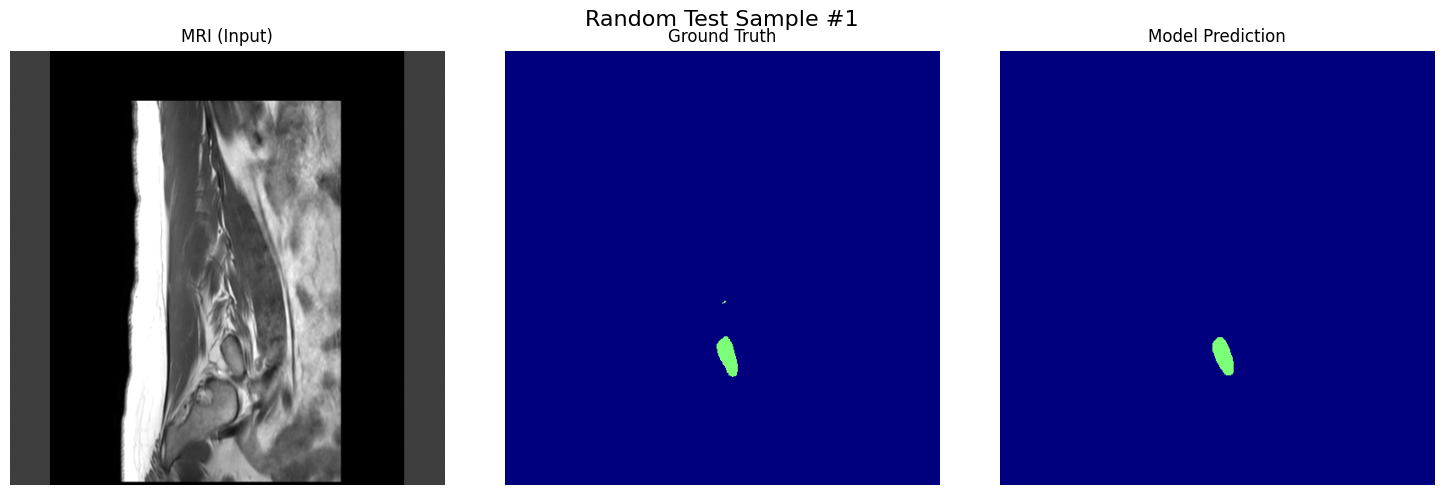

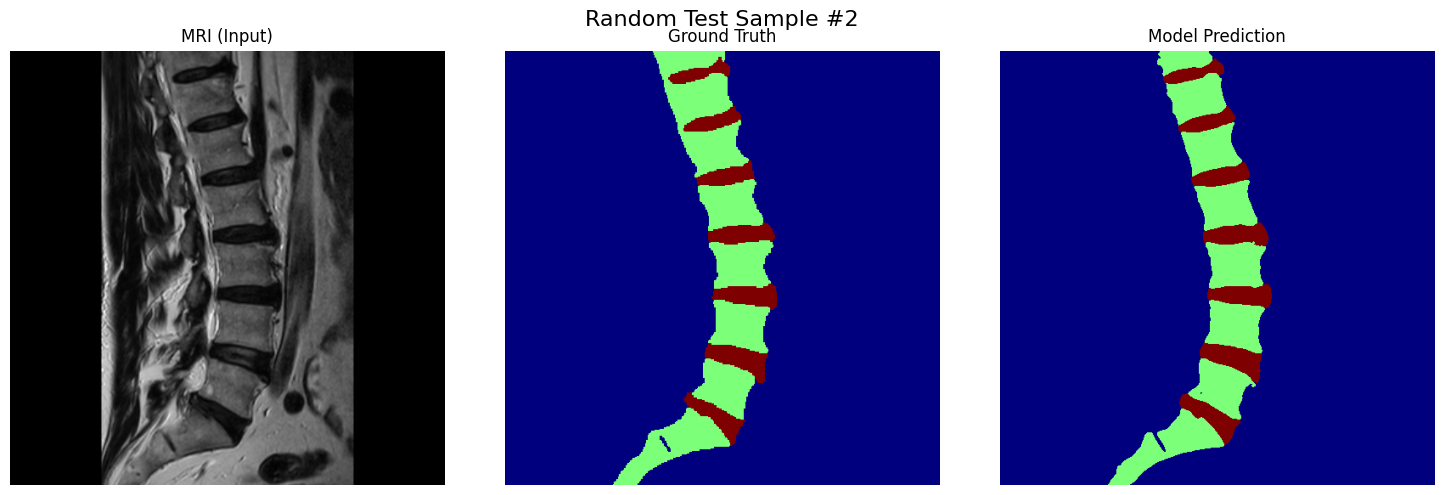

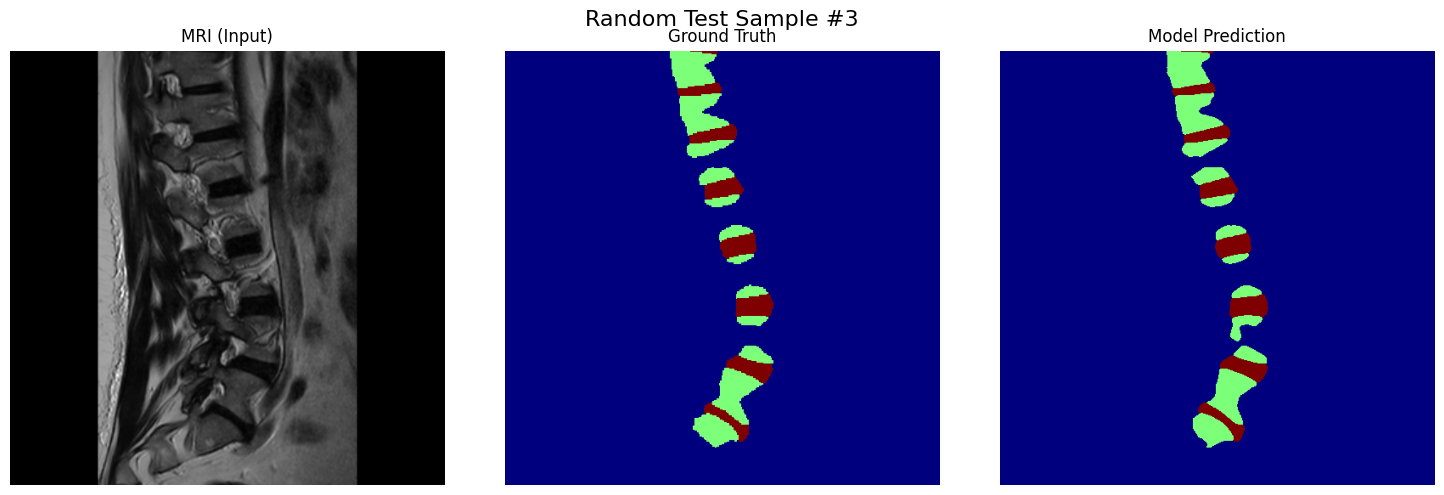

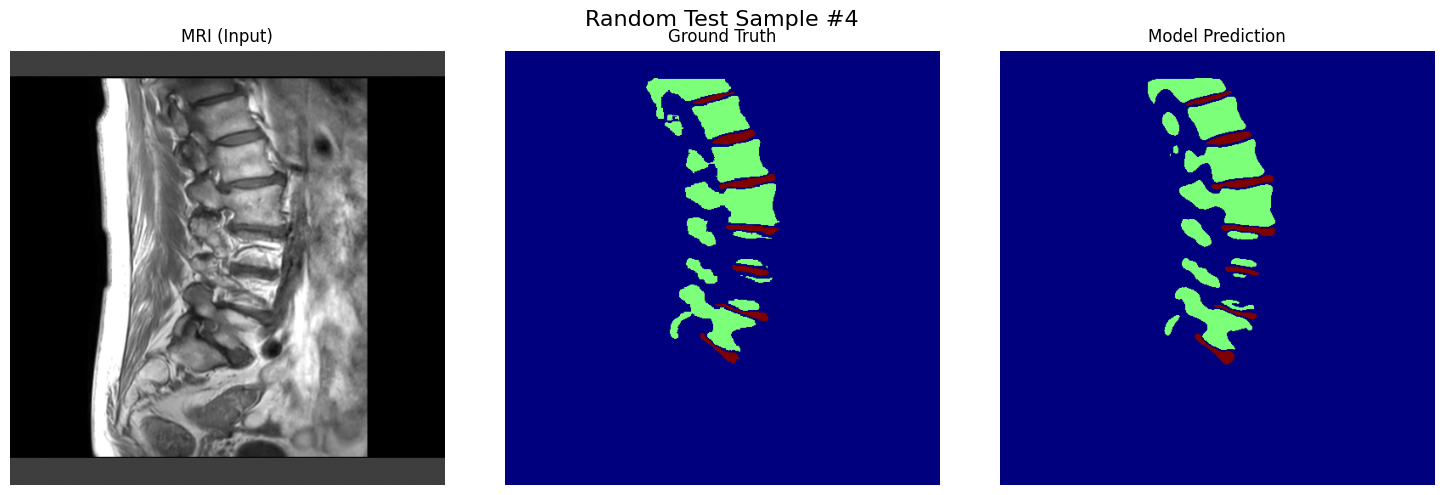

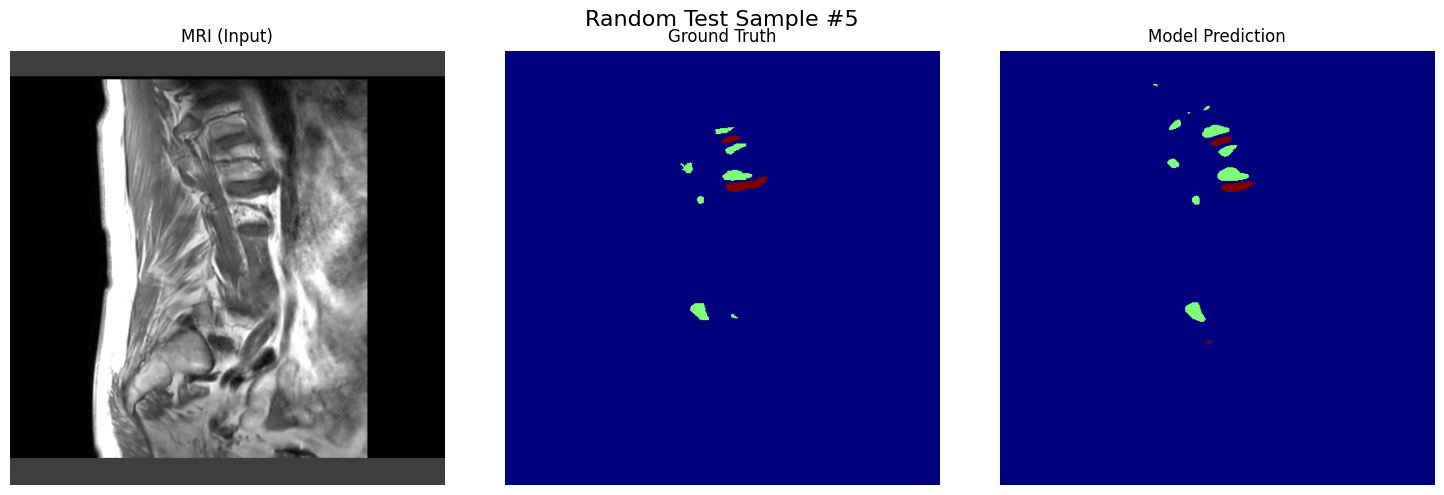

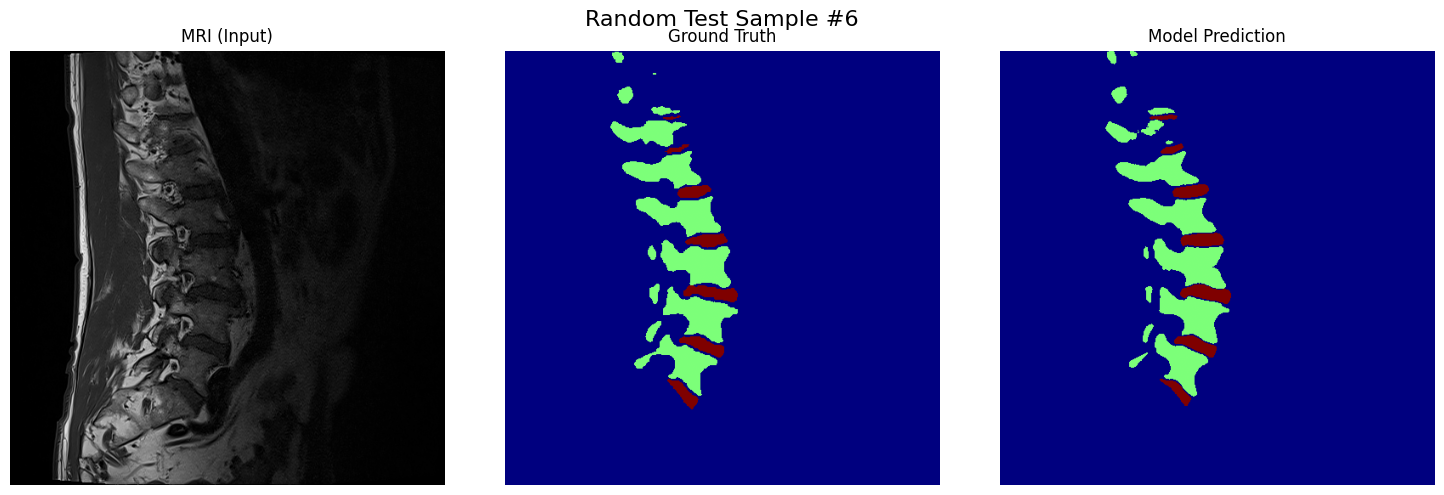

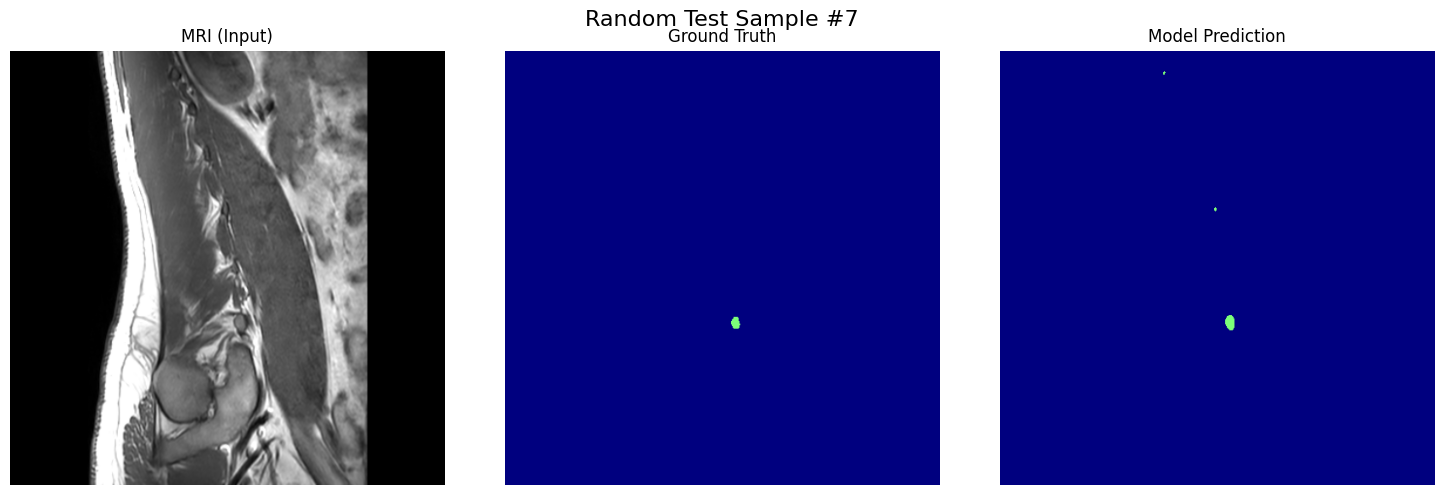

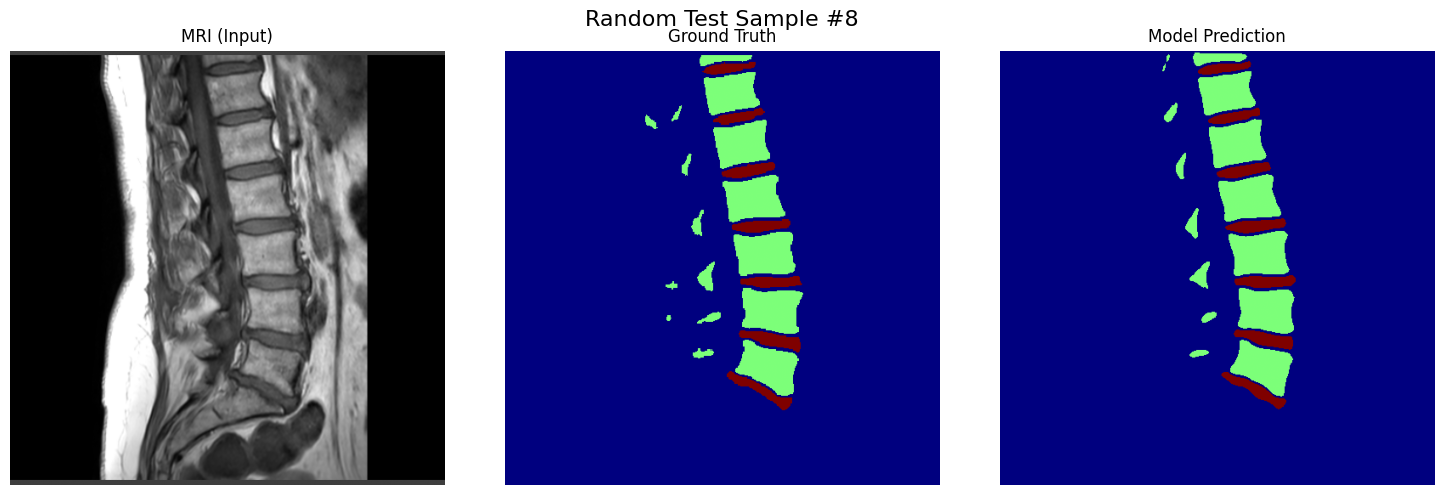

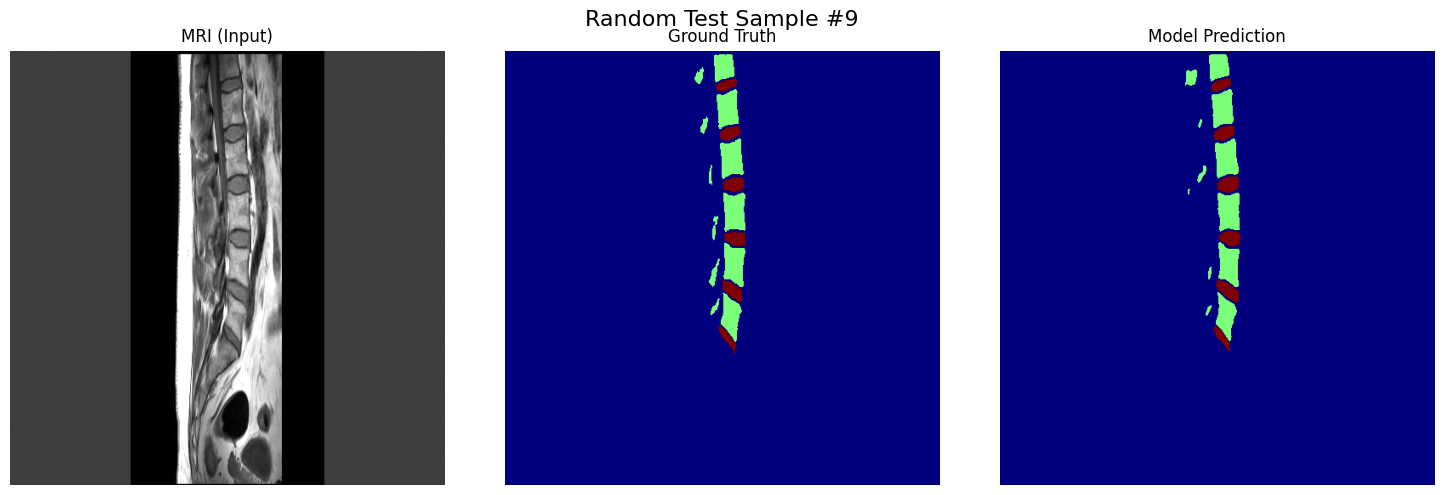

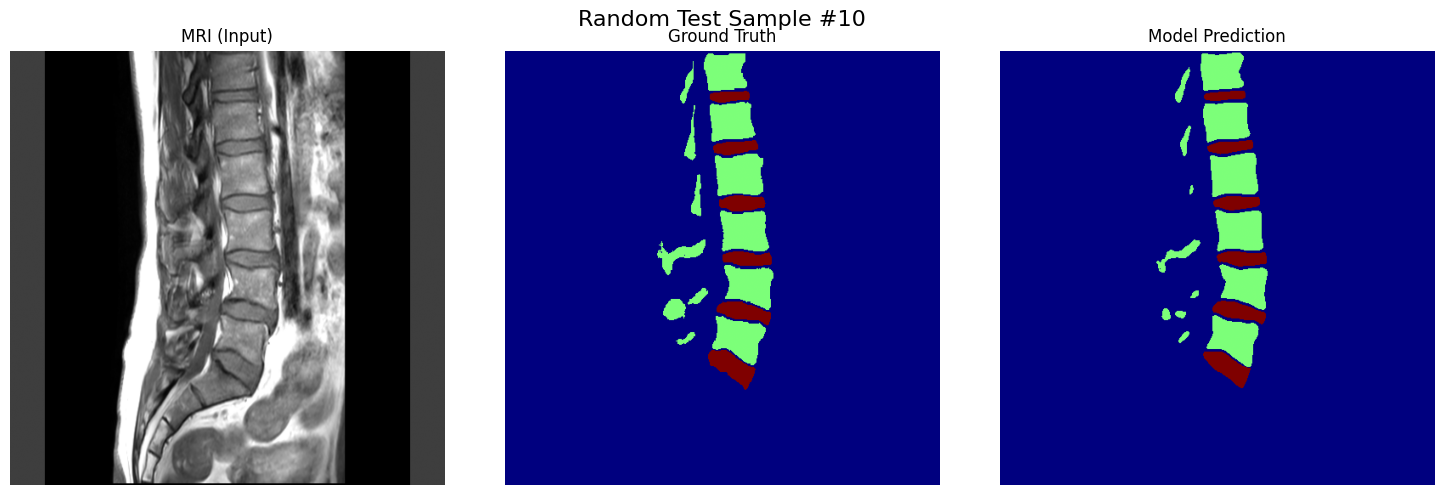

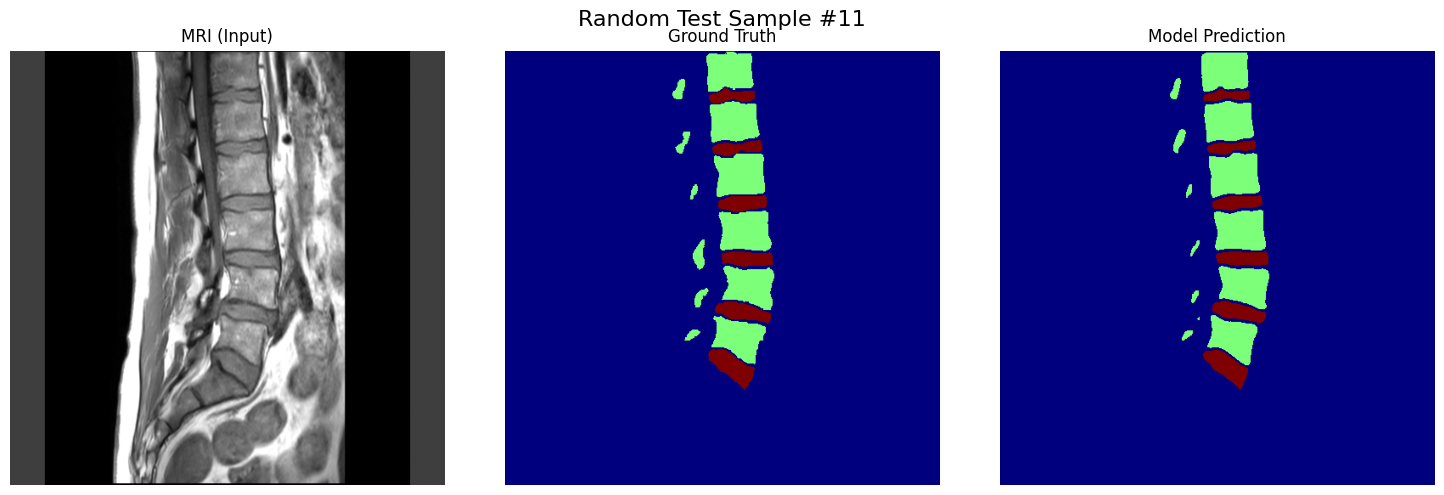

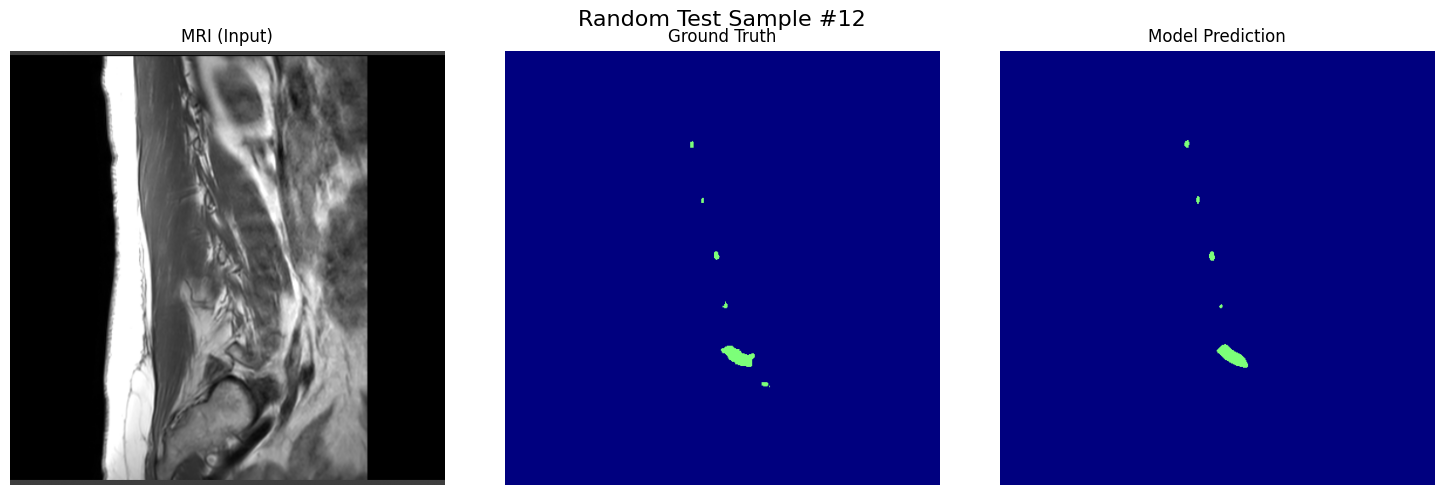

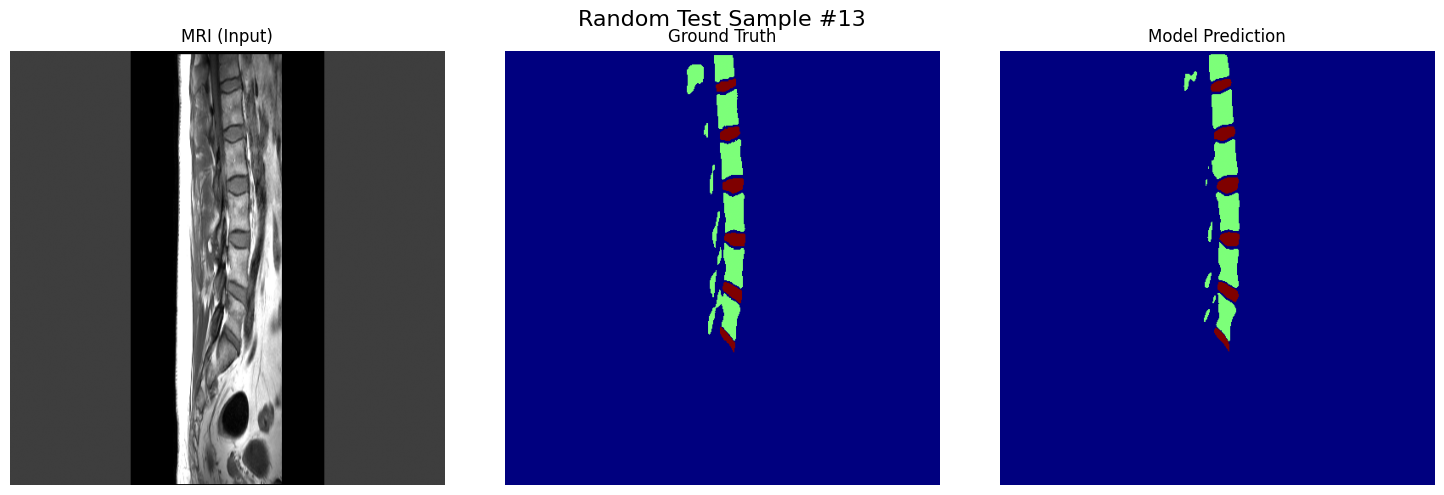

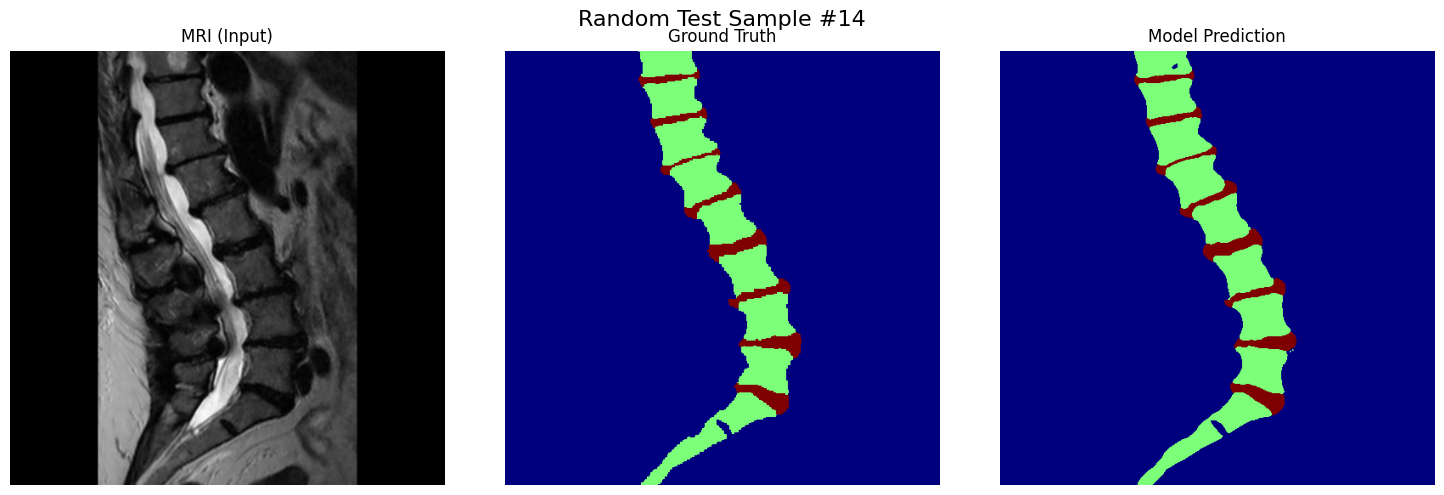

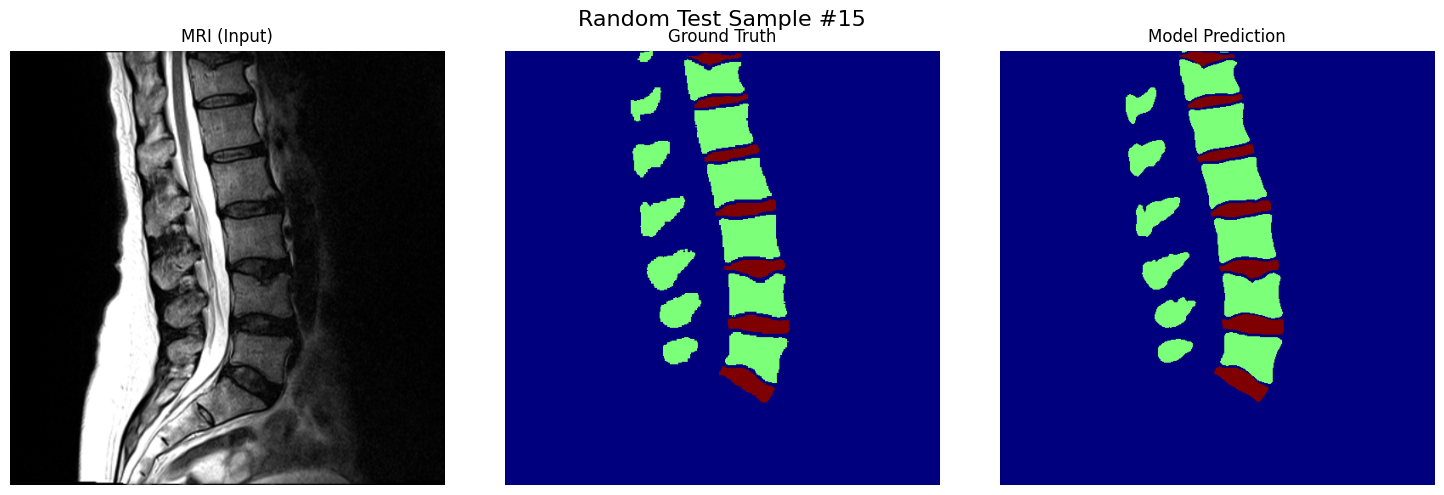

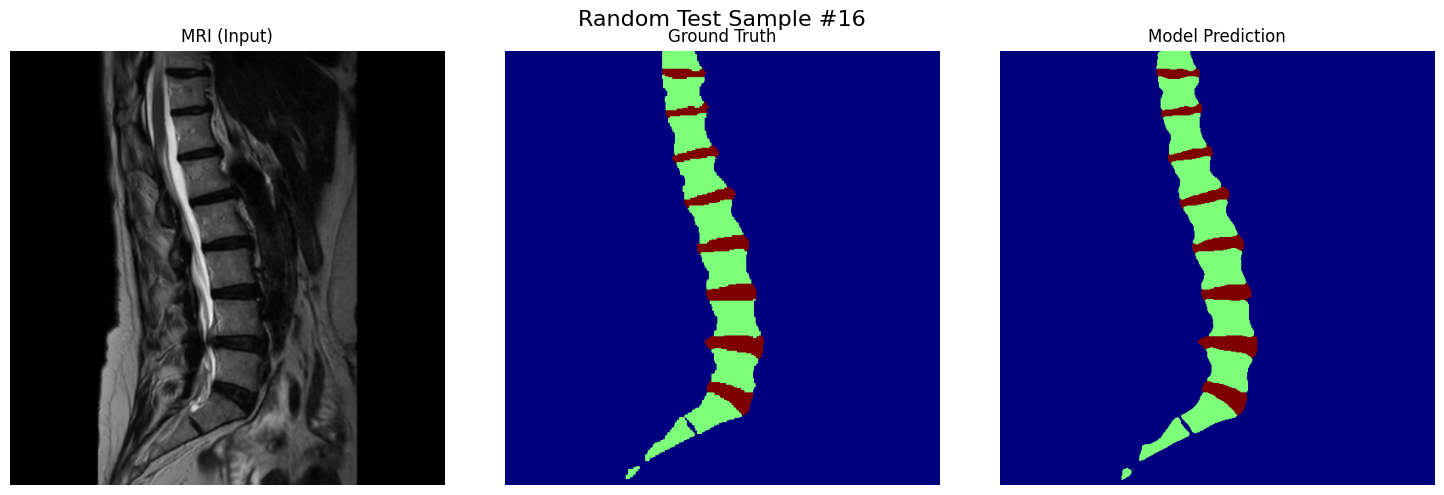

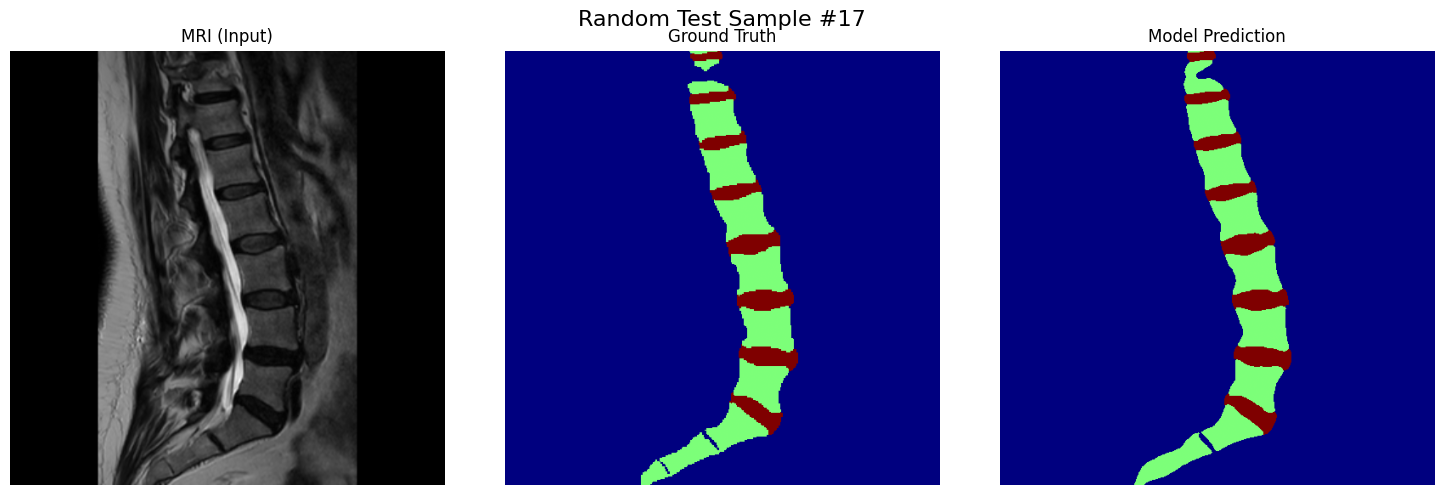

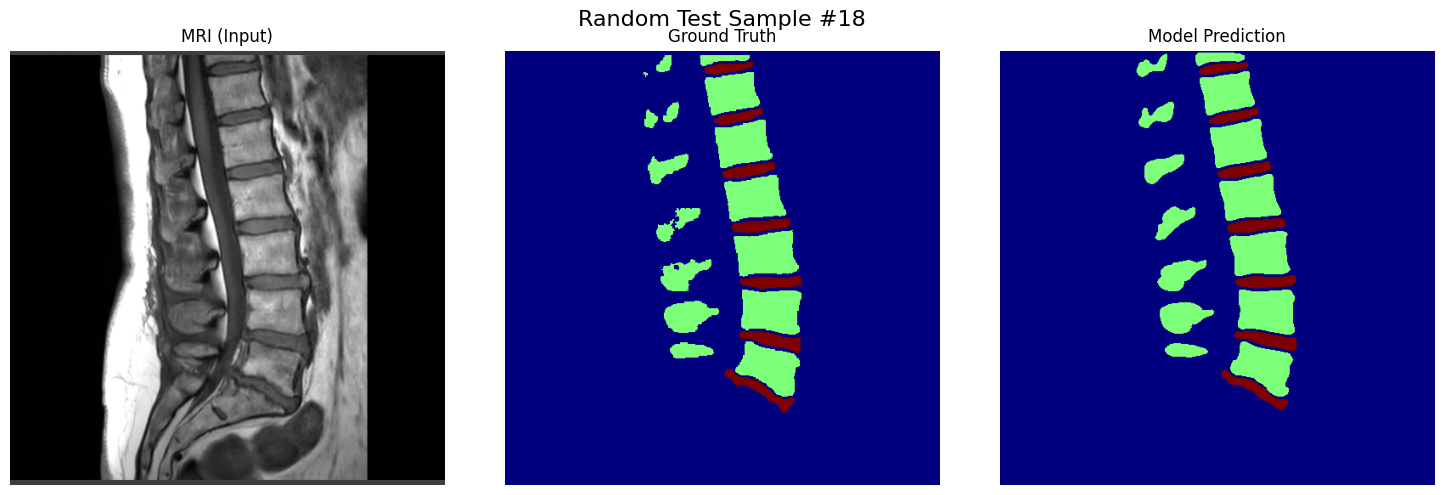

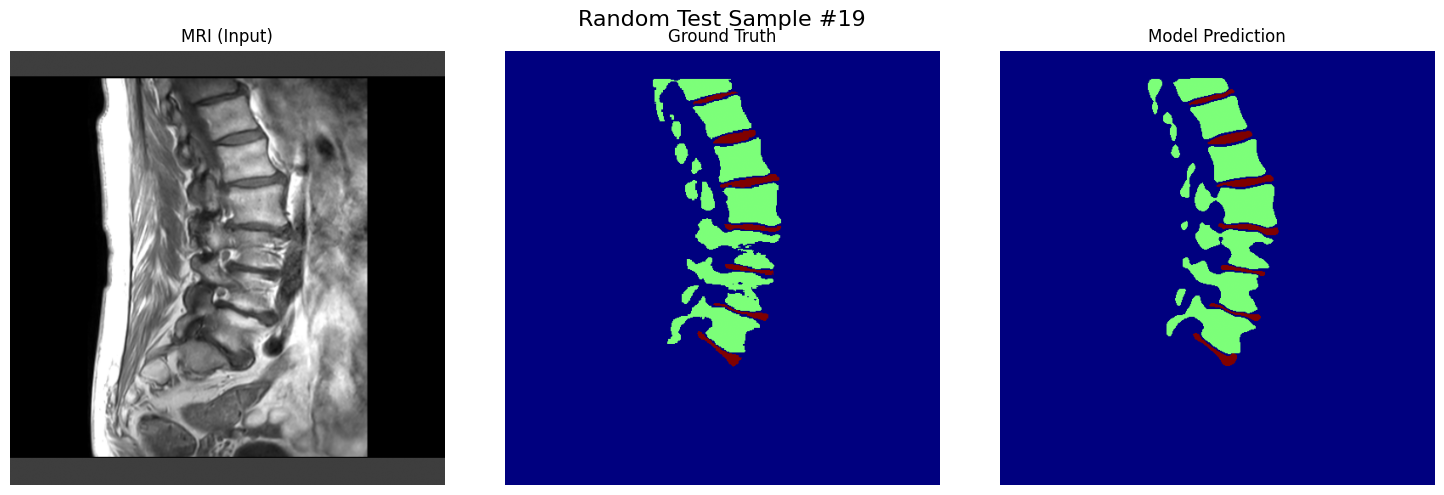

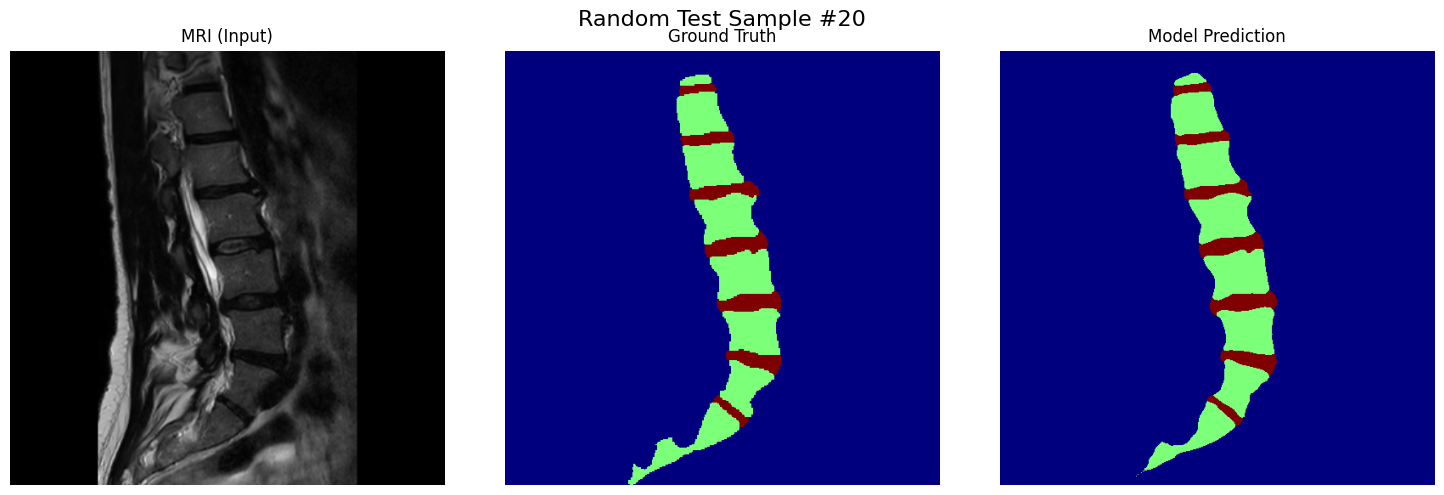

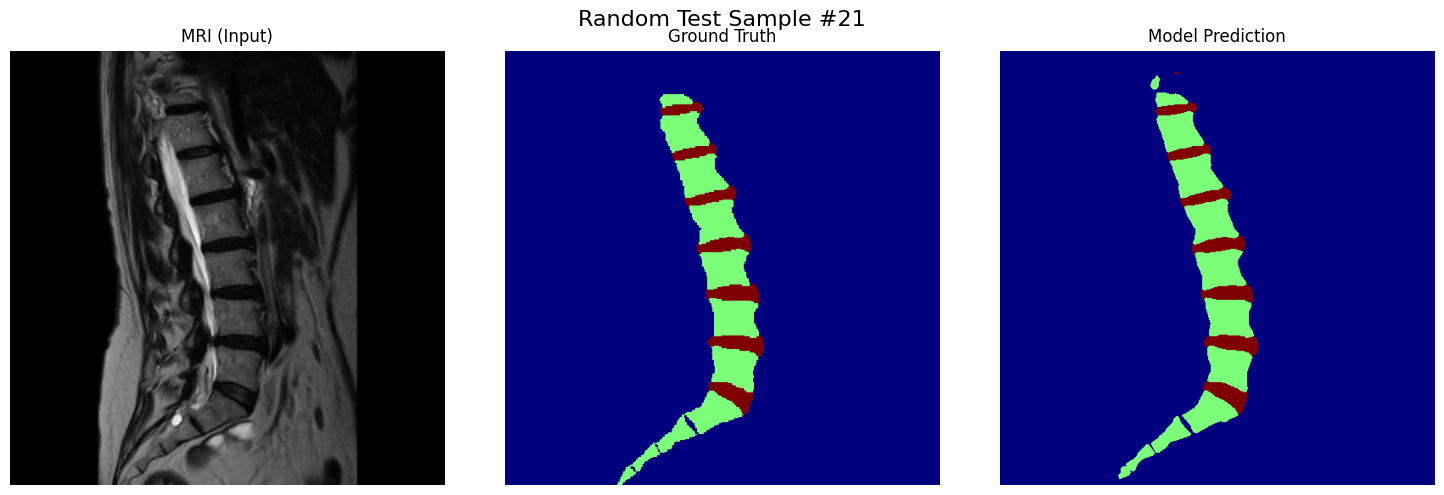

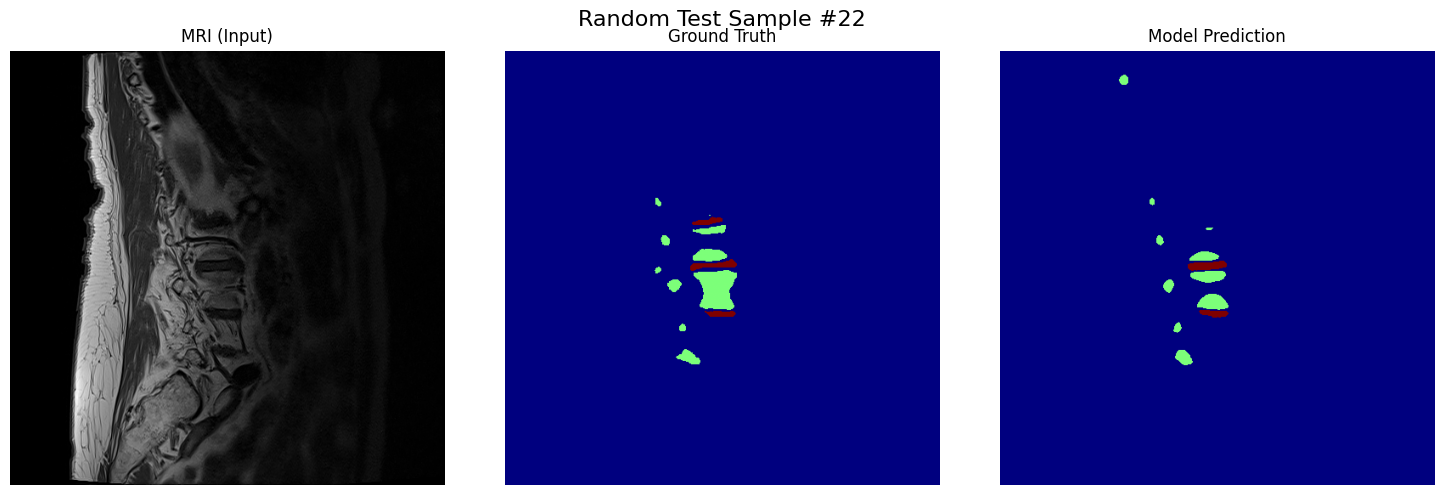

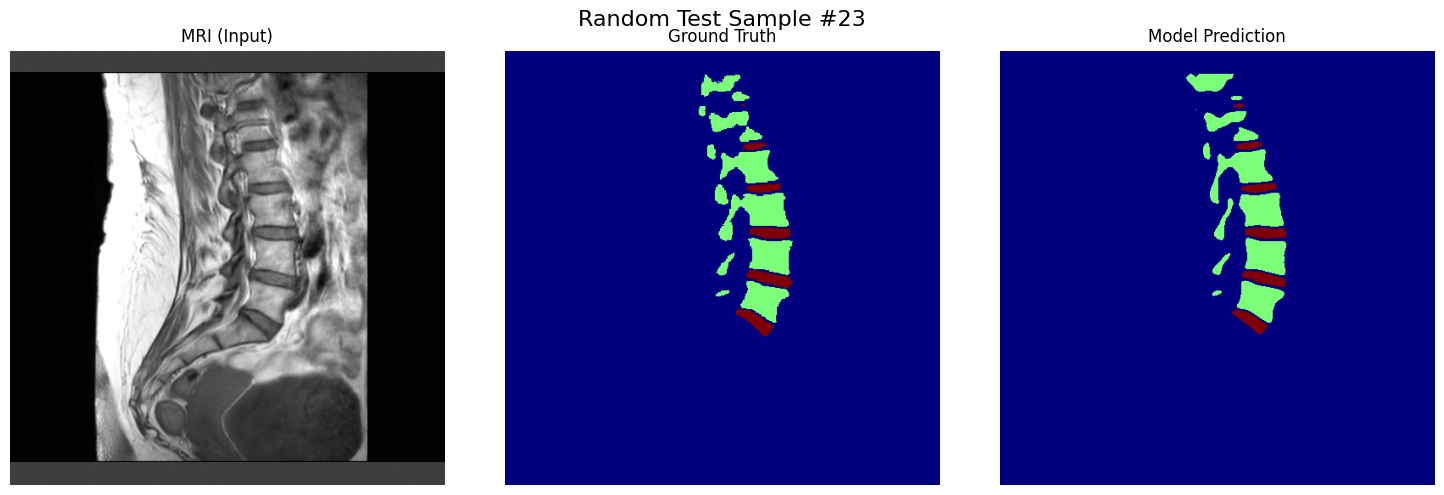

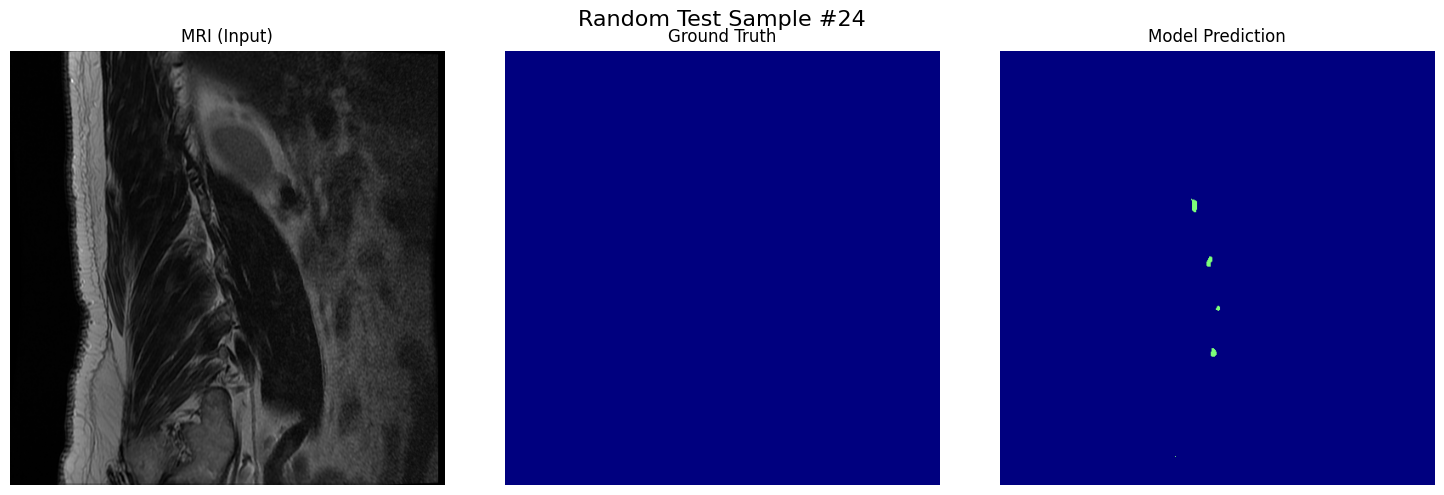

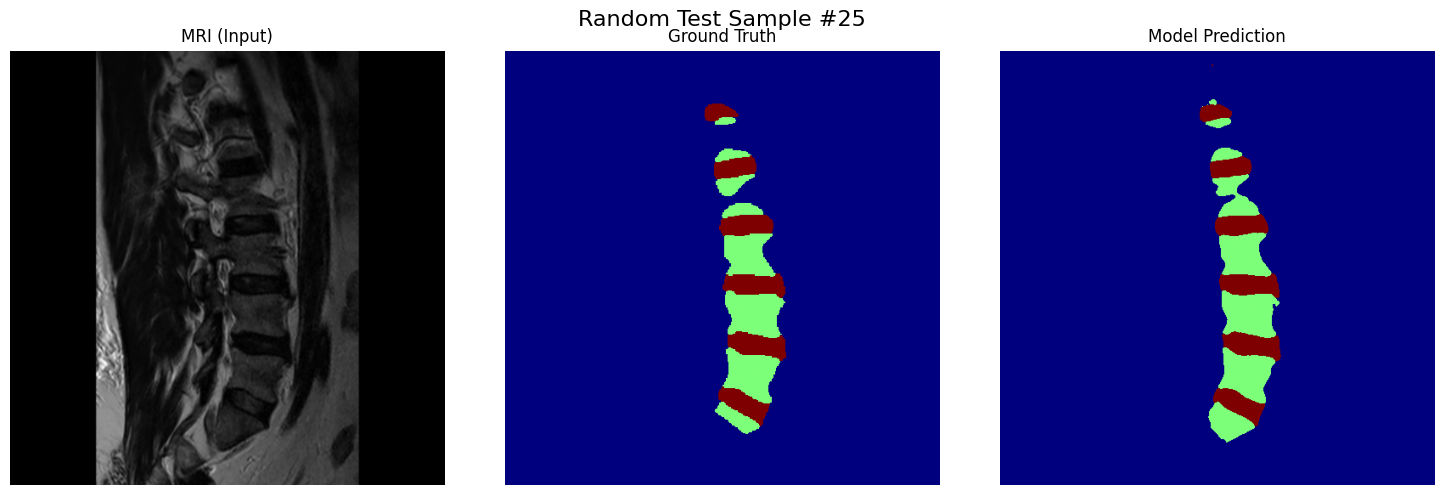

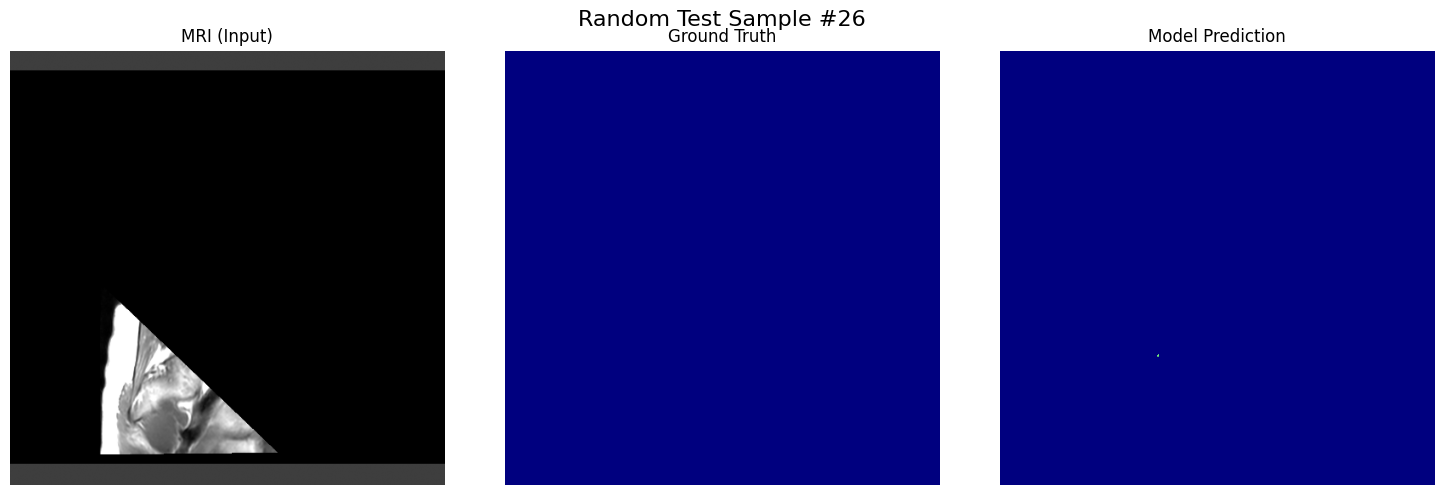

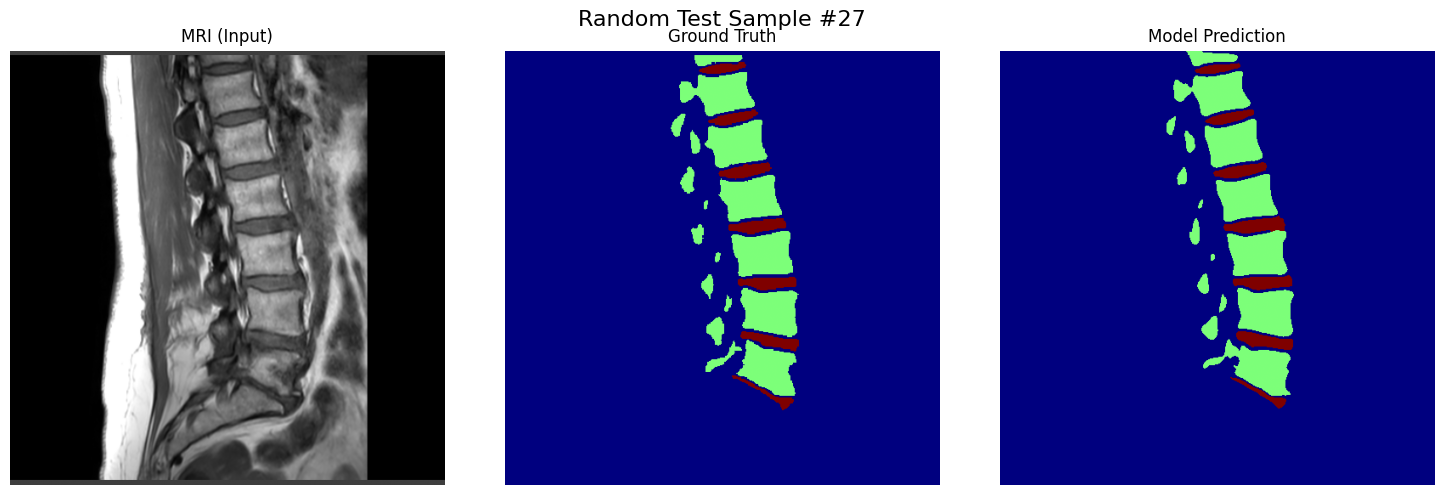

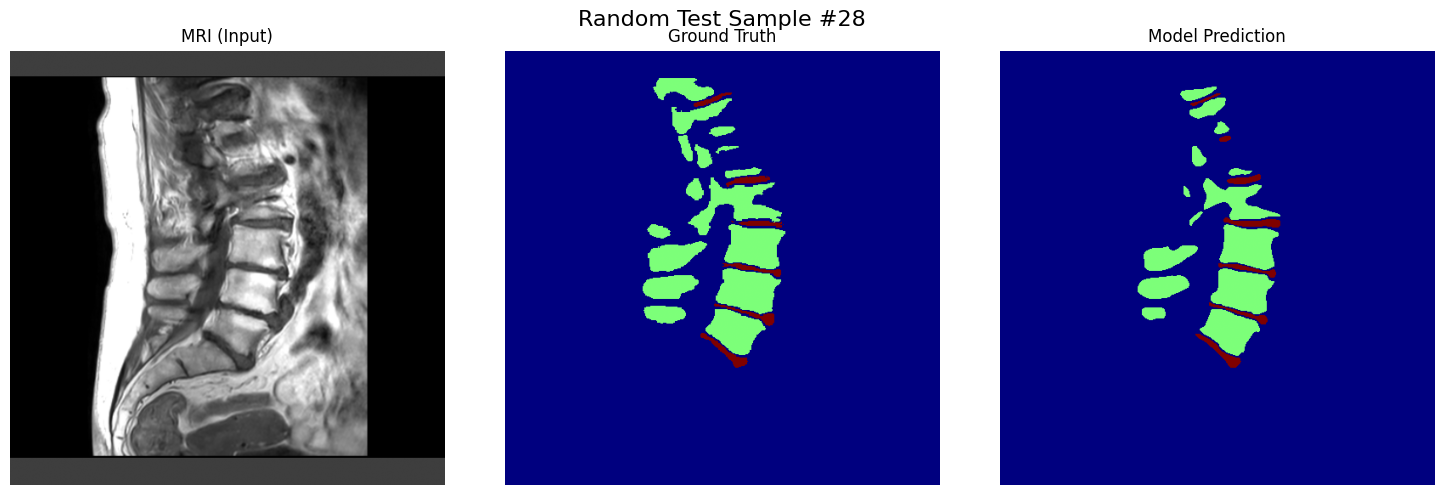

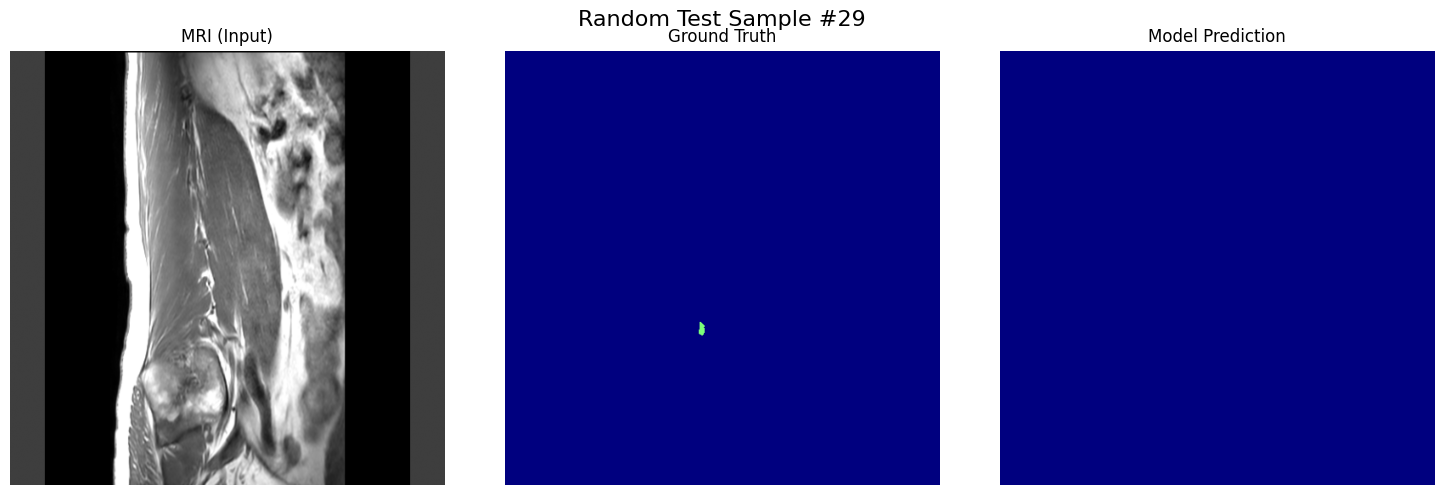

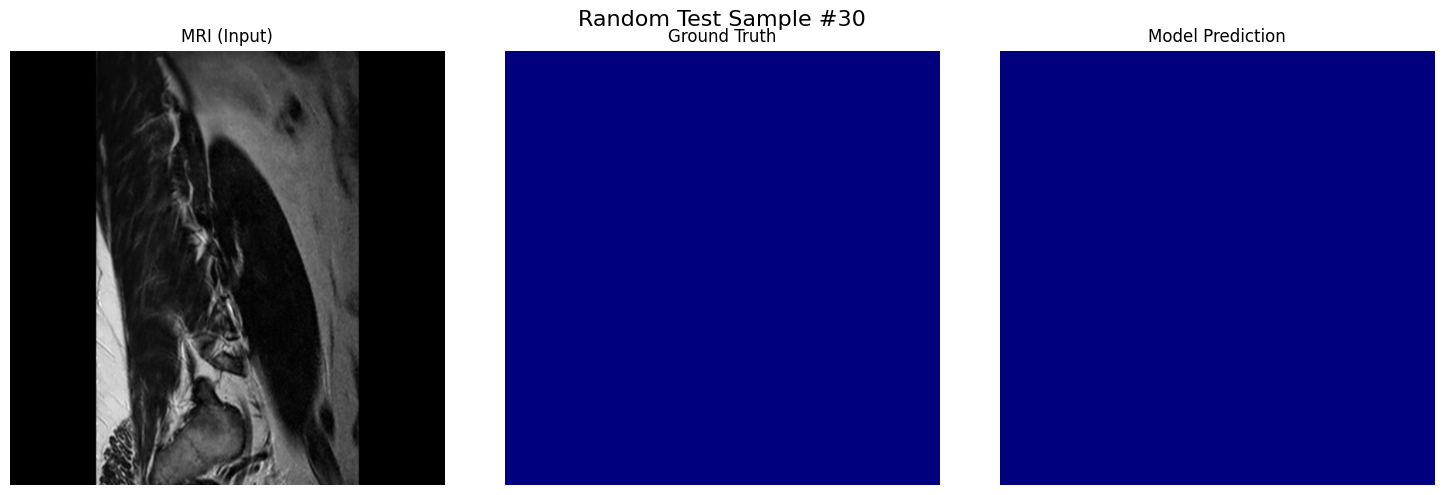

In [4]:
test_loader = data_loading_for_model()[2]
model = ImprovedAttentionUNet(img_ch=1, output_ch=3).to('cuda')
model.load_state_dict(torch.load("best_paper_model.pth"))
evaluate_on_test_set(model, test_loader, 'cuda', num_classes=3, num_visualizations=30, force_rgb=False)